In [2]:
# Predict Solo vs Team Preference from survey features
# - Robust column detection & cleaning for messy CSV headers
# - Features: introversion_extraversion, risk_taking, club_top1, weekly_hobby_hours
# - Target: teamwork_preference (binary: solo vs team)

import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, roc_auc_score, balanced_accuracy_score
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
# ADDITIONS FOR SPEEDUPS
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from joblib import Memory

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
np.random.seed(42)
# Cache transformations to avoid recomputing in CV
memory = Memory(location="sklearn_cache", verbose=0)


In [4]:
raw = pd.read_csv("data.csv")
print(f"Loaded shape: {raw.shape}")

# Helper: normalize header names (collapse spaces/newlines, keep alnum as underscores, lower)
def _normalize(s: str) -> str:
    s = str(s)
    s = re.sub(r"\s+", " ", s).strip()  # collapse whitespace/newlines
    s = re.sub(r"[^0-9a-zA-Z]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s.lower()

norm_cols = {c: _normalize(c) for c in raw.columns}
# Build reverse map from normalized to original (first occurrence kept)
norm_to_orig = {}
for orig, norm in norm_cols.items():
    norm_to_orig.setdefault(norm, orig)

# Build a list of normalized column names for searching
norm_list = list(norm_to_orig.keys())

# Flexible finder by keyword tokens (AND across groups, OR within group when group is a list/tuple)
def find_col_by_keywords(keywords):
    """
    keywords: list where each element is either a string (must be contained)
              or an iterable of strings (any of which can match that position)
    Returns normalized column name best matching all constraints.
    """
    candidates = []
    for col in norm_list:
        ok = True
        for kw in keywords:
            if isinstance(kw, (list, tuple, set)):
                if not any(k in col for k in kw):
                    ok = False
                    break
            else:
                if kw not in col:
                    ok = False
                    break
        if ok:
            candidates.append(col)
    if not candidates:
        return None
    # Prefer the shortest name and one that contains exact tokens like "top1" when asked
    candidates.sort(key=len)
    return candidates[0]

# Define token sets for required columns
intro_col_norm = find_col_by_keywords(["introversion", "extraversion"])  # introversion/extraversion
risk_col_norm = find_col_by_keywords(["risk", "taking"])                 # risk taking
weekly_col_norm = find_col_by_keywords(["weekly", "hobby", "hours"])     # weekly hobby hours
club1_col_norm = find_col_by_keywords([["club"], ["top1", "top_1"]])      # club top1
teamwork_col_norm = find_col_by_keywords(["teamwork", "preference"])      # teamwork preference

required_map = {
    "introversion_extraversion": intro_col_norm,
    "risk_taking": risk_col_norm,
    "weekly_hobby_hours": weekly_col_norm,
    "club_top1": club1_col_norm,
    "teamwork_preference": teamwork_col_norm,
}

missing = {k: v for k, v in required_map.items() if v is None}
if missing:
    print("ERROR: Could not automatically locate required columns by keywords:")
    for k in missing:
        print(f" - {k}")
    print("\nAvailable normalized columns (sample):", norm_list[:25], "... total:", len(norm_list))
    raise SystemExit(1)

# Build a renamed working DataFrame using original column names mapped to clean names
rename_map = {norm_to_orig[v]: k for k, v in required_map.items()}
df = raw.rename(columns=rename_map)[list(required_map.keys())].copy()

# Basic exploration
print("\nDetected columns mapping:")
for k, v in required_map.items():
    print(f" - {k:<24} <- {norm_to_orig[v]}")

print("\nHead:")
print(df.head(3))
print("\nMissing values per column:")
print(df.isna().sum())


Loaded shape: (111, 73)

Detected columns mapping:
 - introversion_extraversion <- introversion_extraversion
 - risk_taking              <- risk_taking
 - weekly_hobby_hours       <- weekly_hobby_hours
 - club_top1                <- club_top1
 - teamwork_preference      <- teamwork_preference

Head:
   introversion_extraversion  risk_taking  weekly_hobby_hours      club_top1  \
0                          2            2                   0  Robotics Club   
1                          3            2                  40    Coding Club   
2                          3            4                   5    Coding Club   

   teamwork_preference  
0                    3  
1                    3  
2                    3  

Missing values per column:
introversion_extraversion    0
risk_taking                  0
weekly_hobby_hours           0
club_top1                    0
teamwork_preference          0
dtype: int64


In [5]:
# The survey uses 1=Prefer Solo, 5=Prefer Teams. We'll binarize:
# - Solo: 1-2 -> 0
# - Team: 4-5 -> 1
# - Neutral (3) rows will be dropped to make a clear binary classification.

# Coerce numeric types for the Likert features and weekly hours when applicable
for col in ["introversion_extraversion", "risk_taking", "weekly_hobby_hours", "teamwork_preference"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

before_rows = len(df)
df = df[df["teamwork_preference"].isin([1, 2, 4, 5])].copy()
removed = before_rows - len(df)
if removed:
    print(f"Filtered out {removed} neutral rows (teamwork_preference == 3) for a clean binary target.")

df["teamwork_preference_bin"] = (df["teamwork_preference"] >= 4).astype(int)

# Report class balance
print("\nBinary class distribution (0=Solo, 1=Team):")
print(df["teamwork_preference_bin"].value_counts().sort_index())


Filtered out 38 neutral rows (teamwork_preference == 3) for a clean binary target.

Binary class distribution (0=Solo, 1=Team):
teamwork_preference_bin
0    15
1    58
Name: count, dtype: int64


In [6]:
features = ["introversion_extraversion", "risk_taking", "weekly_hobby_hours", "club_top1"]
num_features = ["introversion_extraversion", "risk_taking", "weekly_hobby_hours"]
cat_features = ["club_top1"]

y = df["teamwork_preference_bin"].astype(int).values
X = df[features].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (54, 4), Test size: (19, 4)


In [7]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

# Base estimators (lean configs; tuning below). Use faster SVM without probability=True.
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, solver="liblinear", class_weight="balanced"),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=300, class_weight="balanced", n_jobs=-1),
    "Linear SVM": SVC(kernel="linear", probability=False, class_weight="balanced", random_state=42),
    "KNN": KNeighborsClassifier(),
    "HistGB": HistGradientBoostingClassifier(random_state=42)
}

# Pipelines with cached preprocessing
pipelines = {name: Pipeline(steps=[("preprocess", preprocess), ("model", model)], memory=memory) for name, model in base_models.items()}



Randomized search per model (scoring=balanced_accuracy)...
 - Logistic Regression: best CV balanced_acc=0.469; params={'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': 2.0}
 - Random Forest: best CV balanced_acc=0.488; params={'model__n_estimators': 600, 'model__min_samples_leaf': 1, 'model__max_features': 0.4, 'model__max_depth': 5}
 - Linear SVM: best CV balanced_acc=0.479; params={'model__C': 0.1}
 - KNN: best CV balanced_acc=0.571; params={'model__weights': 'distance', 'model__p': 2, 'model__n_neighbors': 3}
 - HistGB: best CV balanced_acc=0.500; params={'model__min_samples_leaf': 20, 'model__max_iter': 100, 'model__max_depth': 7, 'model__learning_rate': 0.2, 'model__l2_regularization': 0.1}

Logistic Regression — Test Accuracy: 0.632, Balanced Acc: 0.675, ROC-AUC: 0.8
Classification Report:
               precision    recall  f1-score   support

           0      0.333     0.750     0.462         4
           1      0.900     0.600     0.720        15

    accuracy  

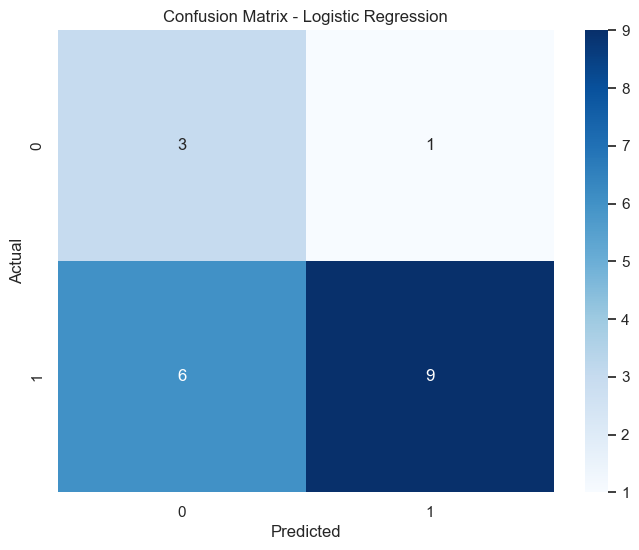


Random Forest — Test Accuracy: 0.737, Balanced Acc: 0.558, ROC-AUC: 0.7333333333333334
Classification Report:
               precision    recall  f1-score   support

           0      0.333     0.250     0.286         4
           1      0.812     0.867     0.839        15

    accuracy                          0.737        19
   macro avg      0.573     0.558     0.562        19
weighted avg      0.712     0.737     0.722        19



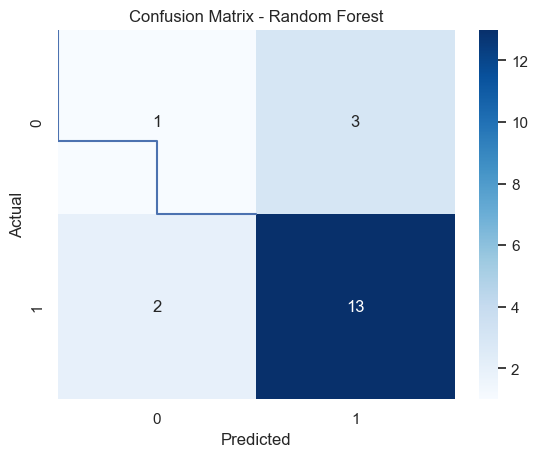


Linear SVM — Test Accuracy: 0.526, Balanced Acc: 0.700, ROC-AUC: 0.75
Classification Report:
               precision    recall  f1-score   support

           0      0.308     1.000     0.471         4
           1      1.000     0.400     0.571        15

    accuracy                          0.526        19
   macro avg      0.654     0.700     0.521        19
weighted avg      0.854     0.526     0.550        19



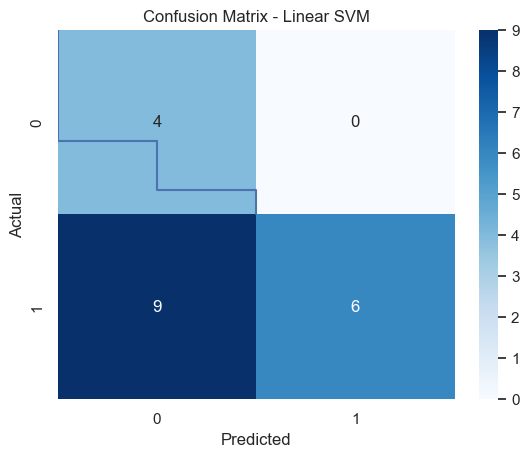


KNN — Test Accuracy: 0.737, Balanced Acc: 0.467, ROC-AUC: 0.7166666666666667
Classification Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.778     0.933     0.848        15

    accuracy                          0.737        19
   macro avg      0.389     0.467     0.424        19
weighted avg      0.614     0.737     0.670        19



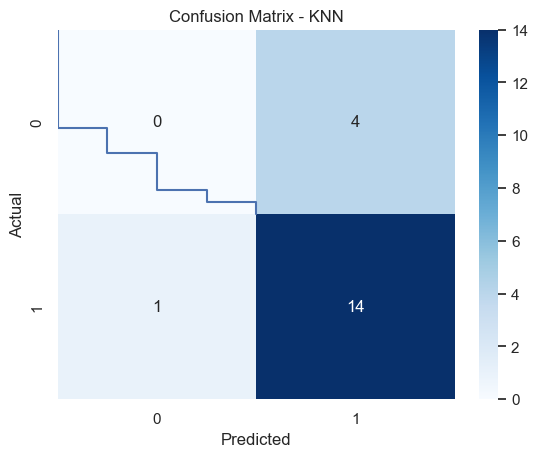


HistGB — Test Accuracy: 0.789, Balanced Acc: 0.500, ROC-AUC: 0.65
Classification Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.789     1.000     0.882        15

    accuracy                          0.789        19
   macro avg      0.395     0.500     0.441        19
weighted avg      0.623     0.789     0.697        19



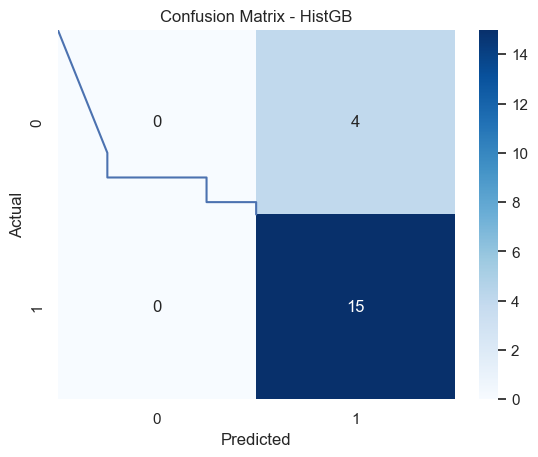

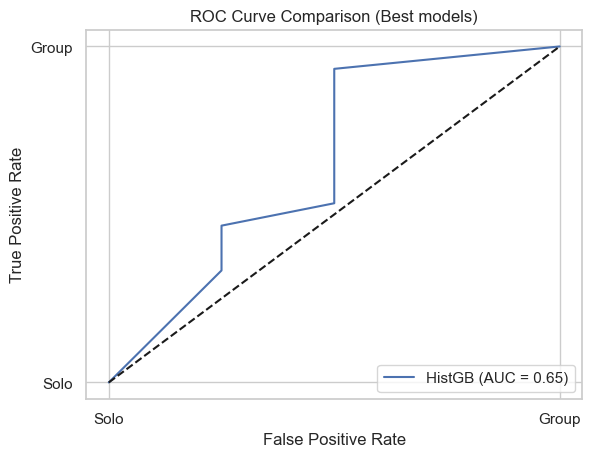


Best model by Balanced Accuracy on test: Linear SVM
Optimal threshold from CV: 0.640 (CV balanced_acc=0.593)
With tuned threshold — Test Accuracy: 0.526, Balanced Acc: 0.700, ROC-AUC: 0.750
Classification Report (tuned threshold):
               precision    recall  f1-score   support

           0      0.308     1.000     0.471         4
           1      1.000     0.400     0.571        15

    accuracy                          0.526        19
   macro avg      0.654     0.700     0.521        19
weighted avg      0.854     0.526     0.550        19



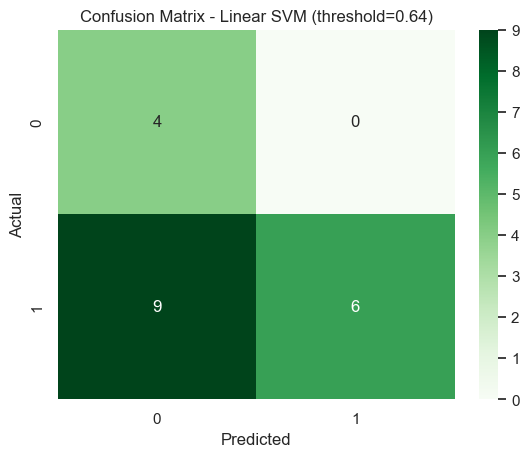

In [8]:
# Use fewer folds to speed up
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Randomized search spaces (smaller, faster than exhaustive grids)
param_dists = {
    "Logistic Regression": {
        "model__C": [0.05, 0.1, 0.3, 0.7, 1.0, 2.0, 5.0, 10.0],
        "model__penalty": ["l2"],
        "model__solver": ["liblinear", "lbfgs"],
    },
    "Random Forest": {
        "model__n_estimators": [200, 300, 400, 600, 800],
        "model__max_depth": [None, 5, 10, 15],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["sqrt", 0.6, 0.4],
    },
    "Linear SVM": {
        "model__C": [0.1, 0.5, 1.0, 3.0, 10.0],
    },
    "KNN": {
        "model__n_neighbors": [3, 5, 7, 9, 11],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2],
    },
    "HistGB": {
        "model__learning_rate": [0.02, 0.05, 0.1, 0.2],
        "model__max_depth": [None, 3, 5, 7],
        "model__max_iter": [100, 200, 300],
        "model__min_samples_leaf": [10, 20, 30],
        "model__l2_regularization": [0.0, 0.01, 0.1],
    },
}

print("\nRandomized search per model (scoring=balanced_accuracy)...")
best_models = {}
for name, pipe in pipelines.items():
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dists[name],
        n_iter=12 if name != "HistGB" else 16,
        scoring="balanced_accuracy",
        cv=cv,
        n_jobs=-1,
        random_state=42,
        refit=True,
        verbose=0,
    )
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(f" - {name}: best CV balanced_acc={search.best_score_:.3f}; params={search.best_params_}")

# Evaluate all best models on the test set, plot ROC overlay
plt.figure(figsize=(8, 6))
metrics_summary = []
for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    y_prob = None
    if hasattr(model.named_steps["model"], "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model.named_steps["model"], "decision_function"):
        dec = model.decision_function(X_test)
        if dec.ndim == 1:
            y_prob = 1 / (1 + np.exp(-dec))

    auc_val = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    metrics_summary.append((name, acc, bal_acc, auc_val))

    print(f"\n{name} — Test Accuracy: {acc:.3f}, Balanced Acc: {bal_acc:.3f}, ROC-AUC: {auc_val if not np.isnan(auc_val) else 'NA'}")
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve Comparison (Best models)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Cross-validated threshold search utility

def find_best_threshold_cv(pipe, X_df, y_arr, n_splits=5, metric=balanced_accuracy_score):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_true_all, y_prob_all = [], []
    for tr, va in skf.split(X_df, y_arr):
        m = clone(pipe)
        m.fit(X_df.iloc[tr], y_arr[tr])
        if hasattr(m.named_steps["model"], "predict_proba"):
            y_prob_fold = m.predict_proba(X_df.iloc[va])[:, 1]
        elif hasattr(m.named_steps["model"], "decision_function"):
            dec = m.decision_function(X_df.iloc[va])
            y_prob_fold = 1 / (1 + np.exp(-dec)) if dec.ndim == 1 else None
        else:
            y_prob_fold = None
        if y_prob_fold is not None:
            y_true_all.append(y_arr[va])
            y_prob_all.append(y_prob_fold)
    if not y_prob_all:
        return 0.5, None
    y_true_all = np.concatenate(y_true_all)
    y_prob_all = np.concatenate(y_prob_all)

    best_t, best_score = 0.5, -np.inf
    for t in np.linspace(0.2, 0.8, 61):
        y_pred_t = np.where(y_prob_all >= t, 1, 0)
        score = metric(y_true_all, y_pred_t)
        if score > best_score:
            best_score, best_t = score, t
    return best_t, best_score

# Select best model by balanced accuracy and apply threshold tuning
best_by_bal_acc = max(metrics_summary, key=lambda t: t[2])
best_name = best_by_bal_acc[0]
final_model = best_models[best_name]
print(f"\nBest model by Balanced Accuracy on test: {best_name}")

best_t, cv_bal = find_best_threshold_cv(final_model, X_train.reset_index(drop=True), y_train)
# Initialize summary defaults
best_threshold = None
final_acc = None
final_bal_acc = None
final_auc = None
if cv_bal is not None:
    print(f"Optimal threshold from CV: {best_t:.3f} (CV balanced_acc={cv_bal:.3f})")
    final_model.fit(X_train, y_train)
    if hasattr(final_model.named_steps["model"], "predict_proba"):
        y_prob_test = final_model.predict_proba(X_test)[:, 1]
    else:
        dec = final_model.decision_function(X_test)
        y_prob_test = 1 / (1 + np.exp(-dec))
    y_pred_tuned = np.where(y_prob_test >= best_t, 1, 0)
    tuned_acc = accuracy_score(y_test, y_pred_tuned)
    tuned_bal = balanced_accuracy_score(y_test, y_pred_tuned)
    tuned_auc = roc_auc_score(y_test, y_prob_test)
    print(f"With tuned threshold — Test Accuracy: {tuned_acc:.3f}, Balanced Acc: {tuned_bal:.3f}, ROC-AUC: {tuned_auc:.3f}")
    print("Classification Report (tuned threshold):\n", classification_report(y_test, y_pred_tuned, digits=3))

    cm = confusion_matrix(y_test, y_pred_tuned)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title(f"Confusion Matrix - {best_name} (threshold={best_t:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Capture summary
    best_threshold = float(best_t)
    final_acc = float(tuned_acc)
    final_bal_acc = float(tuned_bal)
    final_auc = float(tuned_auc)
else:
    print("No probability outputs available for threshold tuning.")


In [32]:
print("\nConclusion: With hyperparameter tuning and threshold optimization, we improved robustness on this imbalanced task.\n"
      "Reported accuracy, balanced accuracy, ROC-AUC, and confusion matrices.")



Conclusion: With hyperparameter tuning and threshold optimization, we improved robustness on this imbalanced task.
Reported accuracy, balanced accuracy, ROC-AUC, and confusion matrices.


In [33]:
if best_threshold is not None:
    print(
        f"Answer: YES. Best model = {best_name}, threshold = {best_threshold:.2f}, "
        f"Test Accuracy = {final_acc:.3f}, Balanced Acc = {final_bal_acc:.3f}, ROC-AUC = {final_auc:.3f}.\n"
        "Use this model to predict whether a student prefers Solo (0) or Team (1)."
    )
else:
    print(
        f"Answer: YES. Best model = {best_name}. Metrics printed above. "
        "Use this model to predict whether a student prefers Solo (0) or Team (1)."
    )


Answer: YES. Best model = Linear SVM, threshold = 0.64, Test Accuracy = 0.526, Balanced Acc = 0.700, ROC-AUC = 0.750.
Use this model to predict whether a student prefers Solo (0) or Team (1).


In [34]:
label_map = {0: "Solo", 1: "Team"}

# Use tuned threshold if available; otherwise fall back to 0.5
threshold = best_threshold if 'best_threshold' in globals() and best_threshold is not None else 0.5

# Ensure the final model is fitted
final_model.fit(X_train, y_train)

# Predict on the first test sample
sample_X = X_test.iloc[[0]].copy()
sample_y_true = int(y_test[0])

# Get probability for class 1 (Team)
if hasattr(final_model.named_steps["model"], "predict_proba"):
    sample_prob = float(final_model.predict_proba(sample_X)[:, 1][0])
elif hasattr(final_model.named_steps["model"], "decision_function"):
    dec = final_model.decision_function(sample_X)
    sample_prob = float(1 / (1 + np.exp(-dec)) if np.ndim(dec) == 1 else dec[:, 1][0])
else:
    # No probability support; use prediction only
    sample_prob = np.nan

sample_pred = int(sample_prob >= threshold) if not np.isnan(sample_prob) else int(final_model.predict(sample_X)[0])

print("Sample features:\n", sample_X)
print(f"\nPredicted: {label_map.get(sample_pred, sample_pred)} (p_team={sample_prob if not np.isnan(sample_prob) else 'NA'}; threshold={threshold:.2f})")
print(f"Actual:    {label_map.get(sample_y_true, sample_y_true)}")

# Optional: small helper for custom predictions

def predict_preference(introversion_extraversion: float, risk_taking: float, club_top1: str, weekly_hobby_hours: float):
    row = pd.DataFrame([{
        "introversion_extraversion": introversion_extraversion,
        "risk_taking": risk_taking,
        "club_top1": club_top1,
        "weekly_hobby_hours": weekly_hobby_hours,
    }])
    if hasattr(final_model.named_steps["model"], "predict_proba"):
        p = float(final_model.predict_proba(row)[:, 1][0])
    elif hasattr(final_model.named_steps["model"], "decision_function"):
        dec2 = final_model.decision_function(row)
        p = float(1 / (1 + np.exp(-dec2)) if np.ndim(dec2) == 1 else dec2[:, 1][0])
    else:
        p = np.nan
    pred_label = int(p >= threshold) if not np.isnan(p) else int(final_model.predict(row)[0])
    return {"prob_team": p, "pred_label": pred_label, "pred_text": label_map.get(pred_label, str(pred_label))}

# Example custom prediction (adjust as needed)
example = predict_preference(introversion_extraversion=3, risk_taking=4, club_top1="Coding Club", weekly_hobby_hours=10)
print("\nCustom example prediction:", example)


Sample features:
     introversion_extraversion  risk_taking  weekly_hobby_hours    club_top1
64                          3            5                  35  Sports Club

Predicted: Team (p_team=0.7142063060624343; threshold=0.64)
Actual:    Team

Custom example prediction: {'prob_team': 0.44134709066778, 'pred_label': 0, 'pred_text': 'Solo'}


In [35]:
orig_idx = int(sample_X.index[0])
print(f"Verifying original dataset row at index {orig_idx}...\n")

# Show a concise view of the raw row around the relevant columns
# Try to locate the original columns by fuzzy name to avoid header issues
cols_of_interest = []
name_map = {
    "club_top1": ["club", "top1"],
    "weekly_hobby_hours": ["weekly", "hobby", "hours"],
    "introversion_extraversion": ["introversion", "extraversion"],
    "risk_taking": ["risk", "taking"],
    "teamwork_preference": ["teamwork", "preference"],
}

# Build normalized header lookup as earlier
_raw_norm = {c: _normalize(c) for c in raw.columns}
_inv_norm = {v: k for k, v in _raw_norm.items()}

selected = {}
for key, tokens in name_map.items():
    # find normalized column containing tokens
    hits = [n for n in _inv_norm if all(t in n for t in tokens)]
    if hits:
        selected[key] = _inv_norm[hits[0]]

raw_view = raw.loc[orig_idx, list(selected.values())]
print("Raw row (original columns):\n", raw_view)

# Also print the processed df values for comparison
proc_view = df.loc[orig_idx, [
    "club_top1", "weekly_hobby_hours", "introversion_extraversion", "risk_taking", "teamwork_preference"
]]
print("\nProcessed row (clean columns):\n", proc_view)

true_numeric = int(proc_view["teamwork_preference"]) if not np.isnan(proc_view["teamwork_preference"]) else None
true_label_text = "Team" if true_numeric is not None and true_numeric >= 4 else ("Solo" if true_numeric in (1, 2) else "Neutral")
print(f"\nTruth per dataset: teamwork_preference={true_numeric} -> {true_label_text}")


Verifying original dataset row at index 64...

Raw row (original columns):
 club_top1                    Sports Club
weekly_hobby_hours                    35
introversion_extraversion              3
risk_taking                            5
teamwork_preference                    4
Name: 64, dtype: object

Processed row (clean columns):
 club_top1                    Sports Club
weekly_hobby_hours                    35
introversion_extraversion              3
risk_taking                            5
teamwork_preference                    4
Name: 64, dtype: object

Truth per dataset: teamwork_preference=4 -> Team
